# PPO Algorithm

This code performs PPO on the Patrolling Zoo environment.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from patrolling_zoo.patrolling_zoo_v0 import parallel_env, PatrolGraph
from algorithm.ppo import PPO, Agent

# set process priority low
import psutil
import os
if os.name == 'nt':
    psutil.Process(os.getpid()).nice(psutil.BELOW_NORMAL_PRIORITY_CLASS)
else:
    psutil.Process(os.getpid()).nice(10)

# Configuration

In [2]:
MAX_CYCLES = 2000

""" ENV SETUP """
patrolGraph = PatrolGraph("patrolling_zoo/env/cumberland.graph")
env = parallel_env(patrolGraph, 3,
    require_explicit_visit=True,
    speed= 1.0,
    alpha=10, # expoonetial bases for reward
    max_cycles=MAX_CYCLES,
    reward_shift = 0.0,
)

"""ALGO PARAMS"""
algo = PPO(
    env = env,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    ent_coef = 0.1,
    vf_coef = 0.1,
    clip_coef = 0.2,
    gamma = 0.99,
    learning_rate = 1e-2,
    batch_size = 512,
    stack_size = 4,
    frame_size = (64, 64),
    num_steps = MAX_CYCLES,
    total_timesteps = 500000,
)

# Training

In [3]:
stats = algo.train()

NameError: name 'clip_fracs' is not defined

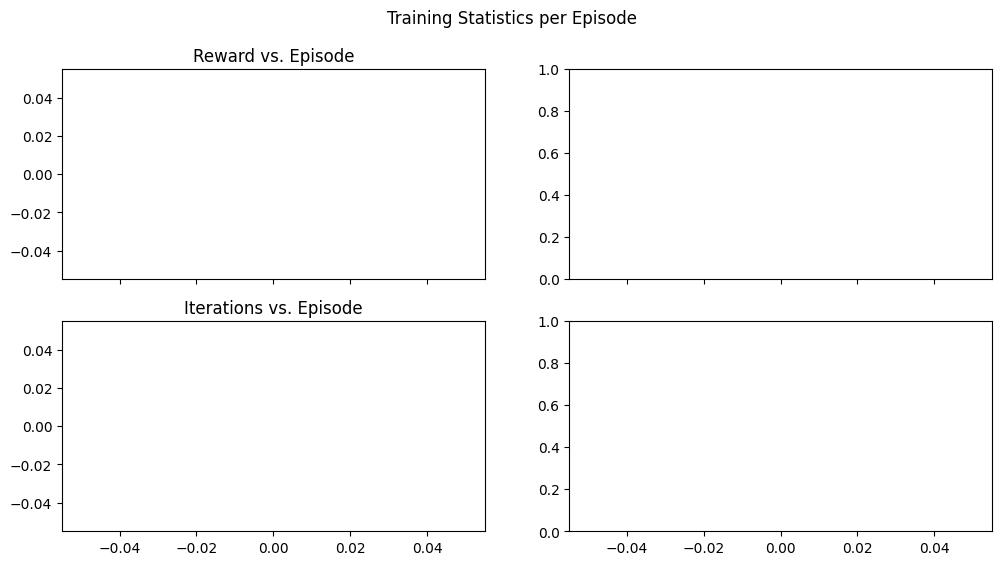

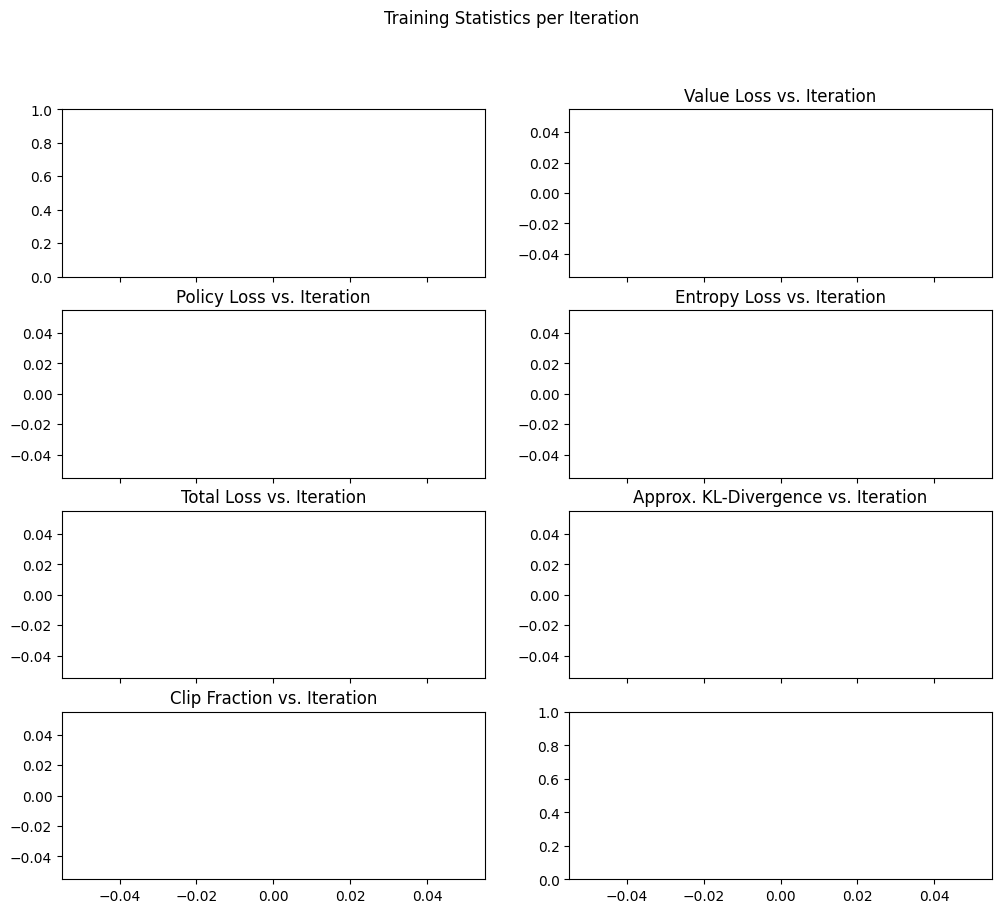

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 6))
fig.suptitle("Training Statistics per Episode")

ax[0, 0].set_title("Reward vs. Episode")
ax[0, 0].plot(stats["episodic_return"])

ax[1, 0].set_title("Iterations vs. Episode")
ax[1, 0].plot(stats["episodic_length"])

plt.show()


fig, ax = plt.subplots(4, 2, sharex=True, figsize=(12, 10))
fig.suptitle("Training Statistics per Iteration")

ax[0, 1].set_title("Value Loss vs. Iteration")
ax[0, 1].plot(stats["value_loss"], label="value_loss")
# ax[0, 1].legend()

ax[1, 0].set_title("Policy Loss vs. Iteration")
ax[1, 0].plot(stats["policy_loss"], label="policy_loss")
# ax[1, 0].legend()

ax[1, 1].set_title("Entropy Loss vs. Iteration")
ax[1, 1].plot(stats["entropy_loss"], label="entropy_loss")
# ax[1, 1].legend()

ax[2, 0].set_title("Total Loss vs. Iteration")
ax[2, 0].plot(stats["total_loss"], label="total_loss")
# ax[2, 0].legend()

ax[2, 1].set_title("Approx. KL-Divergence vs. Iteration")
ax[2, 1].plot(stats["approx_kl"])

ax[3, 0].set_title("Clip Fraction vs. Iteration")
ax[3, 0].plot(stats["clip_frac"])

plt.show()

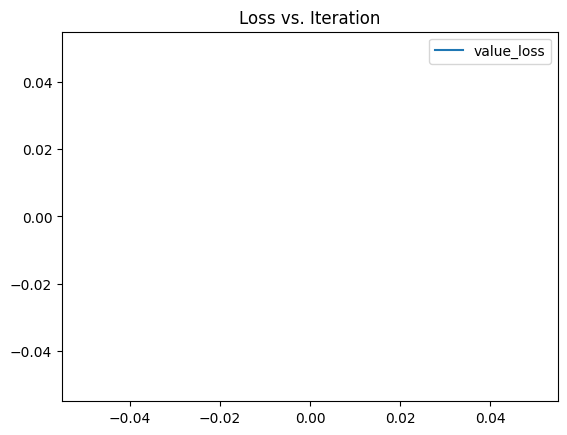

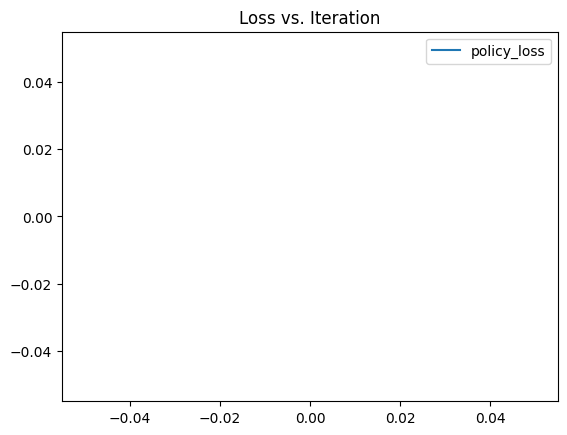

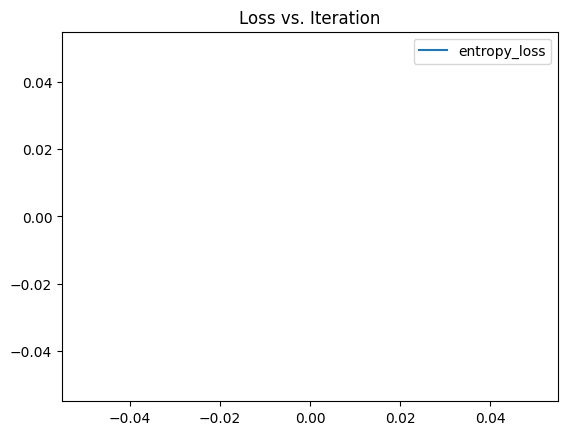

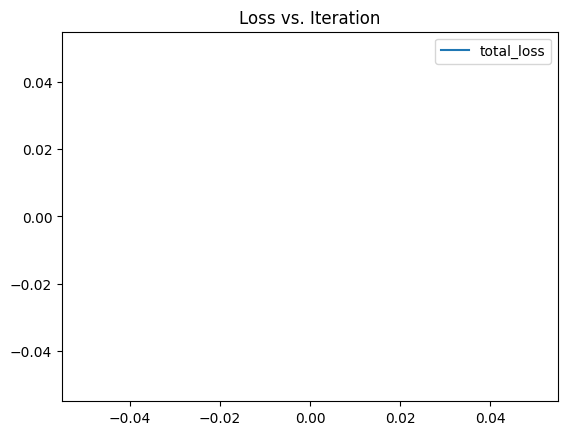

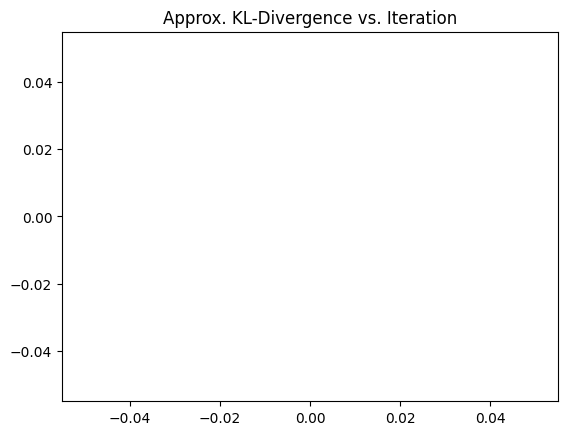

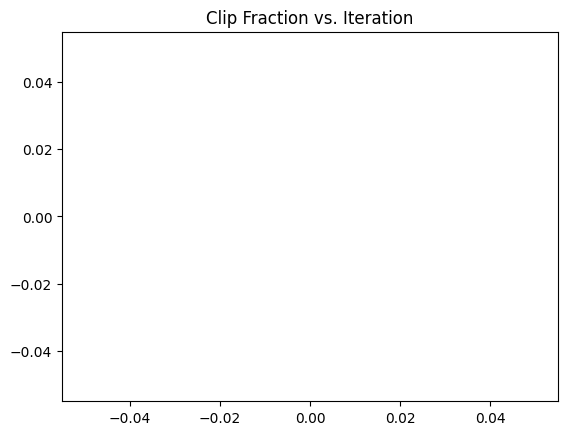

In [ ]:
import matplotlib.pyplot as plt

plt.title("Loss vs. Iteration")
plt.plot(stats["value_loss"], label="value_loss")
plt.legend()
plt.show()

plt.title("Loss vs. Iteration")
plt.plot(stats["policy_loss"], label="policy_loss")
plt.legend()
plt.show()

plt.title("Loss vs. Iteration")
plt.plot(stats["entropy_loss"], label="entropy_loss")
plt.legend()
plt.show()

plt.title("Loss vs. Iteration")
plt.plot(stats["total_loss"], label="total_loss")
plt.legend()
plt.show()

plt.title("Approx. KL-Divergence vs. Iteration")
plt.plot(stats["approx_kl"])
plt.show()

plt.title("Clip Fraction vs. Iteration")
plt.plot(stats["clip_frac"])
plt.show()

# Evaluation

In [ ]:
algo.evaluate(render=True, max_cycles=1)

AttributeError: 'PPO' object has no attribute 'learner'